## SELECTION AND PREPROCESSING OF VARIABLES

After having carried out the Exploratory Data Anlysis, the next step will correspond to the selection and a previous pre-processing of the variables to prepare the dataset for the models. For this, I consider it important to take into account again the conclusions of the EDA that will be the cornerstone in this process.

### EDA CONCLUSIONS

1- The dataset is quite unbalanced since we find very few cases of fraud committed if we compare it with the total data. We'll see what we can do to balance it out.
 
 2- We can determine that fraud is carried out from client to client. Only in these cases does fraud occur, so close attention must be paid to this type of transaction.
 
 3- We find ourselves with a certain number of variables that do not seem to be of considerable importance when it comes to determining whether or not there is fraud. We will see in the selection of variables what their importance is but I consider that they will have little importance.
 
 4- There is a clear pattern of fraud that occurs in most cases. A transfer is made to an account x to later make a cash out of that same amount and leave the account at 0.
 
 5- It is very important to pay attention to (if I had to draw a conclusion right now for the client) the transfers made from client to client, leaving a balance in the original account of 0 and then making a cashout.
 

#### LIBRARIES

In [250]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix

#### Functions

In [279]:
def eliminate_columns(df, list):
       
    for col in list:

        df.drop(col,axis=1,inplace=True)
        
def flag_transaction(df):
    
    df['Flagged_CC'] = np.where(df['Transaction_nature'] == 'C_C', 1, 0)
    df['Flagged_CM'] = np.where(df['Transaction_nature'] == 'C_M', 1, 0)
        
def get_column_pattern(df):
    
    df.loc[df['amount'] == df['oldbalanceOrg'], 'Follows_FraudPattern'] = 1
    df.loc[df['amount'] != df['oldbalanceOrg'], 'Follows_FraudPattern'] = 0  
    
def set_correct_columns(df):
    
    df.columns = ['step', 'type_PAYMENT', 'type_TRANSFER', 'type_CASHOUT', 'type_DEBIT', 'type_CASHIN', 
                    'amount', 'device_MAC', 'device_PC', 'device_IPHONE', 'device_MISSING', 'connection_time ',
                   'oldbalanceOrg', 'age', 'newbalanceOrig','zone_CAPITAL', 'zone_COUNTRY', 'zone_AFRICA', 'zone_MISSING',
                  'user_number ', 'user_connections', 'security_alert', 'oldbalanceDest', 'newbalanceDest',
                  'isFraud', 'Flagged_CC', 'Flagged_CM', 'Follows_FraudPattern']
    
def set_correct_columns_v2(df):
    
    df.columns = ['step', 'type_PAYMENT', 'type_TRANSFER', 'type_CASHOUT', 'type_DEBIT', 'type_CASHIN', 
                    'amount', 'device_MAC', 'device_PC', 'device_IPHONE', 'device_MISSING', 'connection_time ',
                   'oldbalanceOrg', 'age', 'newbalanceOrig','zone_CAPITAL', 'zone_COUNTRY', 'zone_AFRICA', 'zone_MISSING',
                  'user_number ', 'user_connections', 'security_alert', 'oldbalanceDest', 'newbalanceDest',
                  'isFraud', 'Flagged_CC', 'Flagged_CM']
    
def get_feature_importance(x_train):
    
    feature_importance = rf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    # plt.subplot(1, 2, 2)
    plt.figure(figsize=(12, 20))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, x_train.keys()[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    

##### Parametrisation

In [284]:
csv_path = '../data/fraud_dataset_EDA.csv'
seed = 123456
csv_outpath_op1 = '../data/fraud_df_transformed.csv'
csv_outpath_op2 = '../data/fraud_df_processed.csv'

##### Warnings

In [6]:
warnings.filterwarnings('ignore')

##### Data

In [161]:
fraud_df = pd.read_csv(csv_path, sep = ',')

In [162]:
fraud_df.head()

,Unnamed: 0,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,...,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature
0,0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.0,...,160296.36,capital,138,M1979787155,5,1,0.0,0.0,0,C_M
1,1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.0,...,19384.72,country,909,M2044282225,1,0,0.0,0.0,0,C_M
2,2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.0,...,0.00,capital,2569,C553264065,10,0,0.0,0.0,1,C_C
3,3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.0,...,0.00,country,1787,C38997010,3,0,21182.0,0.0,1,C_C
4,4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.0,...,29885.86,country,3997,M1230701703,8,0,0.0,0.0,0,C_M


The first thing we can see is that a variable has slipped in. We remove it.

In [163]:
fraud_df = fraud_df.drop(fraud_df.columns[[0]], axis=1)

In [164]:
fraud_df

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.00,85,160296.36,capital,138,M1979787155,5,1,0.00,0.00,0,C_M
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.00,57,19384.72,country,909,M2044282225,1,0,0.00,0.00,0,C_M
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,0.00,capital,2569,C553264065,10,0,0.00,0.00,1,C_C
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,0.00,country,1787,C38997010,3,0,21182.00,0.00,1,C_C
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.00,90,29885.86,country,3997,M1230701703,8,0,0.00,0.00,0,C_M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,woman,mac,0.420243,C1179511630,black,479803.00,39,347245.65,missing,3179,C435674507,9,0,484329.37,616886.72,0,C_C
1048571,95,PAYMENT,9917.36,woman,mac,0.376169,C1956161225,black,90545.00,36,80627.64,africa,2558,M668364942,9,0,0.00,0.00,0,C_M
1048572,95,PAYMENT,14140.05,unknow,pc,0.837109,C2037964975,black,20545.00,31,6404.95,africa,1553,M1355182933,2,0,0.00,0.00,0,C_M
1048573,95,PAYMENT,10020.05,man,mac,0.480931,C1633237354,black,90605.00,94,80584.95,country,642,M1964992463,8,0,0.00,0.00,0,C_M


### VARIABLES SELECTION

The first thing I've decided to do is create two columns with the fraud patterns we've found. In this way, by adding a 1 for C_C transactions that follow the fraud pattern, we will be able to obtain better results when classifying with the models.

In [165]:
flag_transaction(fraud_df)

In [166]:
fraud_df

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,...,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature,Flagged_CC,Flagged_CM
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.00,85,...,138,M1979787155,5,1,0.00,0.00,0,C_M,0,1
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.00,57,...,909,M2044282225,1,0,0.00,0.00,0,C_M,0,1
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,...,2569,C553264065,10,0,0.00,0.00,1,C_C,1,0
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,...,1787,C38997010,3,0,21182.00,0.00,1,C_C,1,0
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.00,90,...,3997,M1230701703,8,0,0.00,0.00,0,C_M,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,woman,mac,0.420243,C1179511630,black,479803.00,39,...,3179,C435674507,9,0,484329.37,616886.72,0,C_C,1,0
1048571,95,PAYMENT,9917.36,woman,mac,0.376169,C1956161225,black,90545.00,36,...,2558,M668364942,9,0,0.00,0.00,0,C_M,0,1
1048572,95,PAYMENT,14140.05,unknow,pc,0.837109,C2037964975,black,20545.00,31,...,1553,M1355182933,2,0,0.00,0.00,0,C_M,0,1
1048573,95,PAYMENT,10020.05,man,mac,0.480931,C1633237354,black,90605.00,94,...,642,M1964992463,8,0,0.00,0.00,0,C_M,0,1


We already have 0 and 1 with respective columns for transaction types. I prefer to do it this way instead of doing one hot coding.

In [167]:
fraud_df.dtypes

step                    int64
type                   object
amount                float64
gender                 object
device                 object
connection_time       float64
nameOrig               object
race                   object
oldbalanceOrg         float64
age                     int64
newbalanceOrig        float64
zone                   object
user_number             int64
nameDest               object
user_connections        int64
security_alert          int64
oldbalanceDest        float64
newbalanceDest        float64
isFraud                 int64
Transaction_nature     object
Flagged_CC              int64
Flagged_CM              int64
dtype: object

### Fraud Pattern identification

In [168]:
fraud_df[(fraud_df.amount == fraud_df.oldbalanceOrg)]

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,...,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature,Flagged_CC,Flagged_CM
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,...,2569,C553264065,10,0,0.00,0.00,1,C_C,1,0
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,...,1787,C38997010,3,0,21182.00,0.00,1,C_C,1,0
251,1,TRANSFER,2806.00,unknow,pc,0.850314,C1420196421,asian,2806.00,90,...,1413,C972765878,7,0,0.00,0.00,1,C_C,1,0
252,1,CASH_OUT,2806.00,missing,mac,0.331417,C2101527076,asian,2806.00,94,...,2370,C1007251739,6,0,26202.00,0.00,1,C_C,1,0
680,1,TRANSFER,20128.00,woman,pc,0.762768,C137533655,asian,20128.00,6,...,3133,C1848415041,3,0,0.00,0.00,1,C_C,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047888,95,CASH_OUT,56745.14,woman,iphone,0.043478,C526144262,black,56745.14,76,...,800,C79051264,5,1,51433.88,108179.02,1,C_C,1,0
1048221,95,TRANSFER,33676.59,unknow,mac,0.336426,C732111322,asian,33676.59,55,...,4804,C1140210295,4,0,0.00,0.00,1,C_C,1,0
1048222,95,CASH_OUT,33676.59,woman,mac,0.480370,C1000086512,black,33676.59,21,...,1807,C1759363094,7,0,0.00,33676.59,1,C_C,1,0
1048323,95,TRANSFER,87999.25,unknow,missing,0.909998,C927181710,latin,87999.25,41,...,3891,C757947873,8,0,0.00,0.00,1,C_C,1,0


As we see the pattern of fraud can be reduced to the above condition.

In [169]:
get_column_pattern(fraud_df)

In [170]:
fraud_df

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,...,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature,Flagged_CC,Flagged_CM,Follows_FraudPattern
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.00,85,...,M1979787155,5,1,0.00,0.00,0,C_M,0,1,0.0
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.00,57,...,M2044282225,1,0,0.00,0.00,0,C_M,0,1,0.0
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,...,C553264065,10,0,0.00,0.00,1,C_C,1,0,1.0
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,...,C38997010,3,0,21182.00,0.00,1,C_C,1,0,1.0
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.00,90,...,M1230701703,8,0,0.00,0.00,0,C_M,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,woman,mac,0.420243,C1179511630,black,479803.00,39,...,C435674507,9,0,484329.37,616886.72,0,C_C,1,0,0.0
1048571,95,PAYMENT,9917.36,woman,mac,0.376169,C1956161225,black,90545.00,36,...,M668364942,9,0,0.00,0.00,0,C_M,0,1,0.0
1048572,95,PAYMENT,14140.05,unknow,pc,0.837109,C2037964975,black,20545.00,31,...,M1355182933,2,0,0.00,0.00,0,C_M,0,1,0.0
1048573,95,PAYMENT,10020.05,man,mac,0.480931,C1633237354,black,90605.00,94,...,M1964992463,8,0,0.00,0.00,0,C_M,0,1,0.0


In [171]:
fraud_df['Follows_FraudPattern'] = fraud_df['Follows_FraudPattern'].astype('int64')

In [172]:
fraud_df.dtypes

step                      int64
type                     object
amount                  float64
gender                   object
device                   object
connection_time         float64
nameOrig                 object
race                     object
oldbalanceOrg           float64
age                       int64
newbalanceOrig          float64
zone                     object
user_number               int64
nameDest                 object
user_connections          int64
security_alert            int64
oldbalanceDest          float64
newbalanceDest          float64
isFraud                   int64
Transaction_nature       object
Flagged_CC                int64
Flagged_CM                int64
Follows_FraudPattern      int64
dtype: object

In [184]:
fraud_df[fraud_df.Follows_FraudPattern == 1][['Follows_FraudPattern','isFraud']].count()

Follows_FraudPattern    1109
isFraud                 1109
dtype: int64

As we can see the adjustment has been done correctly.

#### Sex and Race

Regarding variables such as race and sex, since it can be a possible or potential cause to generate bias, I have been informing myself and I have found different ideas on this subject. But can we trust that the model will no longer be gender biased? Well, not 100%, but in this case there are not much correlations between gender/race and other variables. Likewise, they are not very relevant variables when it comes to predicting whether there is fraud or not. Therefore I decide to eliminate these two variables and in this way the model will not be able to learn a biased behavior. But as I mentioned, they are irrelevant variables.

In [173]:
column_list = ['gender' , 'race']

In [174]:
eliminate_columns(fraud_df, column_list)
fraud_df

,step,type,amount,device,connection_time,nameOrig,oldbalanceOrg,age,newbalanceOrig,zone,...,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature,Flagged_CC,Flagged_CM,Follows_FraudPattern
0,1,PAYMENT,9839.64,mac,0.140039,C1231006815,170136.00,85,160296.36,capital,...,M1979787155,5,1,0.00,0.00,0,C_M,0,1,0
1,1,PAYMENT,1864.28,mac,0.496890,C1666544295,21249.00,57,19384.72,country,...,M2044282225,1,0,0.00,0.00,0,C_M,0,1,0
2,1,TRANSFER,181.00,pc,0.781150,C1305486145,181.00,66,0.00,capital,...,C553264065,10,0,0.00,0.00,1,C_C,1,0,1
3,1,CASH_OUT,181.00,mac,0.565068,C840083671,181.00,31,0.00,country,...,C38997010,3,0,21182.00,0.00,1,C_C,1,0,1
4,1,PAYMENT,11668.14,mac,0.517114,C2048537720,41554.00,90,29885.86,country,...,M1230701703,8,0,0.00,0.00,0,C_M,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,mac,0.420243,C1179511630,479803.00,39,347245.65,missing,...,C435674507,9,0,484329.37,616886.72,0,C_C,1,0,0
1048571,95,PAYMENT,9917.36,mac,0.376169,C1956161225,90545.00,36,80627.64,africa,...,M668364942,9,0,0.00,0.00,0,C_M,0,1,0
1048572,95,PAYMENT,14140.05,pc,0.837109,C2037964975,20545.00,31,6404.95,africa,...,M1355182933,2,0,0.00,0.00,0,C_M,0,1,0
1048573,95,PAYMENT,10020.05,mac,0.480931,C1633237354,90605.00,94,80584.95,country,...,M1964992463,8,0,0.00,0.00,0,C_M,0,1,0


#### nameDest y nameOrig

I have decided to eliminate these two columns as well, since we have created a new column classifying the type of transaction. Therefore, I consider that these columns are no longer relevant and therefore may be redundant. The same will happen with Transaction nature.

In [175]:
column_list = ['nameOrig', 'nameDest', 'Transaction_nature']

In [186]:
column_list = ['Transaction_nature']

In [187]:
eliminate_columns(fraud_df, column_list)
fraud_df

,step,type,amount,device,connection_time,oldbalanceOrg,age,newbalanceOrig,zone,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Flagged_CC,Flagged_CM,Follows_FraudPattern
0,1,PAYMENT,9839.64,mac,0.140039,170136.00,85,160296.36,capital,138,5,1,0.00,0.00,0,0,1,0
1,1,PAYMENT,1864.28,mac,0.496890,21249.00,57,19384.72,country,909,1,0,0.00,0.00,0,0,1,0
2,1,TRANSFER,181.00,pc,0.781150,181.00,66,0.00,capital,2569,10,0,0.00,0.00,1,1,0,1
3,1,CASH_OUT,181.00,mac,0.565068,181.00,31,0.00,country,1787,3,0,21182.00,0.00,1,1,0,1
4,1,PAYMENT,11668.14,mac,0.517114,41554.00,90,29885.86,country,3997,8,0,0.00,0.00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,mac,0.420243,479803.00,39,347245.65,missing,3179,9,0,484329.37,616886.72,0,1,0,0
1048571,95,PAYMENT,9917.36,mac,0.376169,90545.00,36,80627.64,africa,2558,9,0,0.00,0.00,0,0,1,0
1048572,95,PAYMENT,14140.05,pc,0.837109,20545.00,31,6404.95,africa,1553,2,0,0.00,0.00,0,0,1,0
1048573,95,PAYMENT,10020.05,mac,0.480931,90605.00,94,80584.95,country,642,8,0,0.00,0.00,0,0,1,0


### Final appreciations of the selection of variables

Regarding the rest of the variables, I have decided to keep them. I consider that there are variables that are not very relevant given the previous study that we have done. However, I cannot know for sure to what extent removing these variables can harm the model, that is why I prefer to keep them so that the model works a little more and has enough variables to optimize, rather than losing predictive power or there is a lot of overfitting. Therefore, for the rest of the categorical variables, a one hot encoding will be carried out since they are variables with few categories.

### Coding categorical variables

In [188]:
fraud_df.dtypes

step                      int64
type                     object
amount                  float64
device                   object
connection_time         float64
oldbalanceOrg           float64
age                       int64
newbalanceOrig          float64
zone                     object
user_number               int64
user_connections          int64
security_alert            int64
oldbalanceDest          float64
newbalanceDest          float64
isFraud                   int64
Flagged_CC                int64
Flagged_CM                int64
Follows_FraudPattern      int64
dtype: object

In [191]:
list_columns_cat = ['type', 'device', 'zone']
ohe = ce.OneHotEncoder(cols=list_columns_cat)
model = ohe.fit(fraud_df)
fraud_df_transformed = model.transform(fraud_df)

In [204]:
fraud_df_transformed.dtypes

step                      int64
type_1                    int64
type_2                    int64
type_3                    int64
type_4                    int64
type_5                    int64
amount                  float64
device_1                  int64
device_2                  int64
device_3                  int64
device_4                  int64
connection_time         float64
oldbalanceOrg           float64
age                       int64
newbalanceOrig          float64
zone_1                    int64
zone_2                    int64
zone_3                    int64
zone_4                    int64
user_number               int64
user_connections          int64
security_alert            int64
oldbalanceDest          float64
newbalanceDest          float64
isFraud                   int64
Flagged_CC                int64
Flagged_CM                int64
Follows_FraudPattern      int64
dtype: object

In [207]:
set_correct_columns(fraud_df_transformed)
fraud_df_transformed

,step,type_PAYMENT,type_TRANSFER,type_CASHOUT,type_DEBIT,type_CASHIN,amount,device_MAC,device_PC,device_IPHONE,...,zone_MISSING,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Flagged_CC,Flagged_CM,Follows_FraudPattern
0,1,1,0,0,0,0,9839.64,1,0,0,...,0,138,5,1,0.00,0.00,0,0,1,0
1,1,1,0,0,0,0,1864.28,1,0,0,...,0,909,1,0,0.00,0.00,0,0,1,0
2,1,0,1,0,0,0,181.00,0,1,0,...,0,2569,10,0,0.00,0.00,1,1,0,1
3,1,0,0,1,0,0,181.00,1,0,0,...,0,1787,3,0,21182.00,0.00,1,1,0,1
4,1,1,0,0,0,0,11668.14,1,0,0,...,0,3997,8,0,0.00,0.00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,0,0,1,0,0,132557.35,1,0,0,...,1,3179,9,0,484329.37,616886.72,0,1,0,0
1048571,95,1,0,0,0,0,9917.36,1,0,0,...,0,2558,9,0,0.00,0.00,0,0,1,0
1048572,95,1,0,0,0,0,14140.05,0,1,0,...,0,1553,2,0,0.00,0.00,0,0,1,0
1048573,95,1,0,0,0,0,10020.05,1,0,0,...,0,642,8,0,0.00,0.00,0,0,1,0


### Test of the model with the new selected variables

#### We separate between train and test with a ratio of 75-25

In [210]:
x = fraud_df_transformed.drop('isFraud', axis = 1)
y = fraud_df_transformed.isFraud
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, stratify=y , random_state=seed)

The reason I've decided to split train and test now is so that variable treatment is applied to test as well.

#### We scale variables

In [222]:
scaler = StandardScaler()
model_scaled = scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#### Model Check

In [233]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train);
print(rf)
print("model score: %.3f" % rf.score(X_test, Y_test))

RandomForestRegressor()
model score: 0.980


In [252]:
predictions = rf.predict(X_test)
errors = abs(predictions - Y_test)

In [241]:
print('Mean Absolute Error:', round(np.mean(errors), 4))

Mean Absolute Error: 0.0001


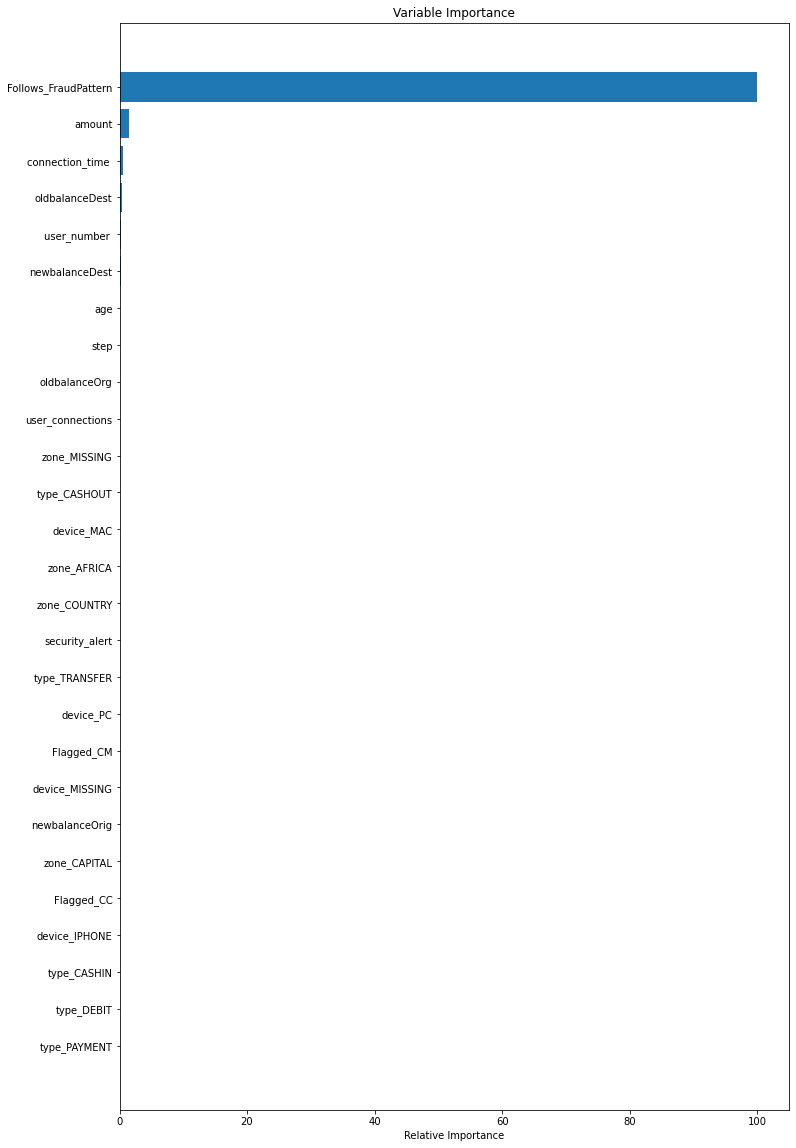

In [254]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### WHAT CONCLUSIONS DO WE DRAW?

According to the results that we have obtained through this previous process, I have concluded that for these data the pattern of fraud is extremely clear. However, this can be counterproductive since we are greatly limiting the predictive power to comply with that specific pattern. What would happen if the pattern of fraud is changed? Therefore, I have decided to change my initial scheme and eliminate this variable in order to give the model more freedom when it comes to predicting. I also think that even if we eliminate the variable that discriminates the pattern, we will still get good results with the client-to-client variable.

According to these conclusions I proceed to leave the adjusted dataframe.

In [266]:
fraud_df_processed = pd.read_csv(csv_path, sep = ',')
fraud_df_processed = fraud_df_processed.drop(fraud_df_processed.columns[[0]], axis=1)
flag_transaction(fraud_df_processed)
fraud_df_processed

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,...,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud,Transaction_nature,Flagged_CC,Flagged_CM
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.00,85,...,138,M1979787155,5,1,0.00,0.00,0,C_M,0,1
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.00,57,...,909,M2044282225,1,0,0.00,0.00,0,C_M,0,1
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.00,66,...,2569,C553264065,10,0,0.00,0.00,1,C_C,1,0
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.00,31,...,1787,C38997010,3,0,21182.00,0.00,1,C_C,1,0
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.00,90,...,3997,M1230701703,8,0,0.00,0.00,0,C_M,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,woman,mac,0.420243,C1179511630,black,479803.00,39,...,3179,C435674507,9,0,484329.37,616886.72,0,C_C,1,0
1048571,95,PAYMENT,9917.36,woman,mac,0.376169,C1956161225,black,90545.00,36,...,2558,M668364942,9,0,0.00,0.00,0,C_M,0,1
1048572,95,PAYMENT,14140.05,unknow,pc,0.837109,C2037964975,black,20545.00,31,...,1553,M1355182933,2,0,0.00,0.00,0,C_M,0,1
1048573,95,PAYMENT,10020.05,man,mac,0.480931,C1633237354,black,90605.00,94,...,642,M1964992463,8,0,0.00,0.00,0,C_M,0,1


In [267]:
column_list = ['gender' , 'race', 'nameOrig', 'nameDest', 'Transaction_nature']

In [268]:
eliminate_columns(fraud_df_processed, column_list)

In [269]:
model = ohe.fit(fraud_df_processed)
fraud_df_processed = model.transform(fraud_df_processed)

In [273]:
fraud_df_processed.dtypes

step                  int64
type_1                int64
type_2                int64
type_3                int64
type_4                int64
type_5                int64
amount              float64
device_1              int64
device_2              int64
device_3              int64
device_4              int64
connection_time     float64
oldbalanceOrg       float64
age                   int64
newbalanceOrig      float64
zone_1                int64
zone_2                int64
zone_3                int64
zone_4                int64
user_number           int64
user_connections      int64
security_alert        int64
oldbalanceDest      float64
newbalanceDest      float64
isFraud               int64
Flagged_CC            int64
Flagged_CM            int64
dtype: object

In [275]:
set_correct_columns_v2(fraud_df_processed)

In [277]:
x = fraud_df_processed.drop('isFraud', axis = 1)
y = fraud_df_processed.isFraud
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, stratify=y , random_state=seed)

In [278]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train);
print(rf)
print("model score: %.3f" % rf.score(X_test, Y_test))

RandomForestRegressor()
model score: 0.790


We obviously got a lower score. However, I believe that by adapting the models we will achieve a better score.

### Final appreciations

I have been thinking about it a lot and I have considered the following. If this were a real case and the data were the ones we are working with, avoiding the fraud pattern is a clear mistake since the fraud committed is clear. In the case of not using it, I consider that we would be making a mistake since the data follows a very clear pattern. Therefore I have thought of raising the models with two cases: 1. Not following the pattern, 2. Following the pattern.

#### Dataframes Export

##### Option 1

In [285]:
fraud_df_transformed.to_csv(csv_outpath_op1)

##### Option  2

In [286]:
fraud_df_processed.to_csv(csv_outpath_op2)